
# Layout




🌌 Background

El càncer de mama és el més comú entre les dones del món. Representa el 25% de tots els casos de càncer i va afectar més de 2,1 milions de persones només el 2015. Comença quan les cèl·lules de la mama comencen a créixer de manera descontrolada. Aquestes cèl·lules solen formar tumors que es poden veure mitjançant raigs X o sentir-se com embalums a la zona del pit.

✅ Objectius

- Comprendre el conjunt de dades i netejar-lo (si cal).
    Construir models de classificació per predir si el tipus de càncer és maligne o benigne, variable "diagnosi" 0 benigne i 1 maligne.
    També ajustar els hiperparàmetres i comparar les mètriques davaluació de diversos algorismes de classificació.

📈 Dataset

Per poder entrenar el model clickeu al següent link: Download train

I per poder avaluar-vos tindreu el següent conjunt de dades per al testeig: Download test
Submission

Per realizar l'entrega es demana un fitxer csv amb el nom "predictions.csv" on estará la columna de diagnosis amb un 0 o 1, en funció de si es benigne o maligne. Notar que cada fila del predictions correspon a la predicció de la fila del test amb les dades.
Evaluation

L'avaluació es tindrà en compte el següent:

- 400/600:(OBJECTIUS) Això s'obtindrà a partir de la puntuació (macro) f1 del model predictiu. Comparant les prediccions que ha fet el vostre model sobre test_x versus la veritat terrestre.


- 200/600:(OBJECTIUS) Si ets capaç d'automatitzar l'extracció de dades dels PDF i incorporar-les a la formació del model. S'atorgaran 100 punts.


Stack proposat:

    Python
    
    
### Imports

In [1]:
# Yolo!!!
import warnings
warnings.filterwarnings('ignore')

# Scientific and Data Manipulation Libraries :
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb

# ML Libraries
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve  
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


# Other Settings
%matplotlib inline
sb.set()

### (Methods)

In [2]:
def outliers(feature):
# Prints an outlier resume about one feature
    # calculate interquartile range
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q75 - q25
    print(f'{feature.name.upper()}')
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in feature if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    non_outliers = [x for x in feature if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(non_outliers))
    proportion = len(outliers)/len(non_outliers)*100
    print(f'Outlier Percentage: {proportion:.2f} %\n')
 


In [3]:
def check_distribution(df):
# Shows number of features and prompts for M and N (rows and columns)
# Returns a Multiplot Histogram of each variable in a MxN Grid.
    
    # Inputs
    df = pd.DataFrame(df)
    variables = df.columns
    print(f'Number of variables = {len(variables)}')
    n_rows = int(input('Desired Num of rows: '))
    n_cols = int(input('Desired Num of columns: '))
    
    #Plot
    sb.set(font_scale=1.2) 
    fig=plt.figure(figsize=(12,12))
    fig.patch.set_facecolor('slategrey')
    fig.suptitle('FEATURE DISTRIBUTION')
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=50, ax=ax)
        ax.set_title(var_name, size=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    fig.tight_layout()
    plt.show()
    plt.close('all')

    

In [4]:
def select_features(X_train, y_train, X_test):
    # Select all features
    fs = SelectKBest(score_func=f_classif, k='all' )
    
    # Learn relationship from training data
    fs.fit(X_train, y_train)
   
    return fs



In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]



--- 

# Exploratory Data Analysis
___

### Read the train.csv data 
 

In [6]:
data = pd.read_csv('C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\Hackathon ITAcademy\\train.csv')
data = pd.DataFrame(data, columns=data.columns)

### Display Data info

In [7]:
display(data.describe(include='all'))
display(data.info())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.373626,14.139000,19.306286,92.086044,657.829890,0.096849,0.105557,0.090775,0.049585,0.181319,...,16.276679,25.823099,107.319516,882.553187,0.133482,0.256997,0.278242,0.115695,0.290325,0.084309
std,0.484299,3.625935,4.267421,24.998077,363.536865,0.013981,0.052932,0.080993,0.039159,0.027140,...,4.897917,6.123728,34.025815,574.721873,0.022902,0.157587,0.211802,0.065949,0.059696,0.018168
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.116700,...,7.930000,12.020000,50.410000,185.200000,0.081250,0.034320,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.705000,16.210000,75.015000,419.250000,0.086740,0.066735,0.030180,0.020720,0.162050,...,12.980000,21.350000,84.290000,513.950000,0.118350,0.151650,0.119350,0.065080,0.251550,0.071835
50%,0.000000,13.300000,18.890000,85.980000,546.400000,0.096860,0.094860,0.063870,0.033840,0.179700,...,14.990000,25.440000,97.660000,688.600000,0.132600,0.215600,0.229900,0.099930,0.283300,0.080190
75%,1.000000,15.740000,21.795000,103.650000,777.250000,0.106050,0.130450,0.132200,0.074490,0.195800,...,18.550000,29.990000,124.950000,1047.000000,0.147950,0.333800,0.387200,0.161950,0.317500,0.092070
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.577400,0.207500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                455 non-null    int64  
 1   radius_mean              455 non-null    float64
 2   texture_mean             455 non-null    float64
 3   perimeter_mean           455 non-null    float64
 4   area_mean                455 non-null    float64
 5   smoothness_mean          455 non-null    float64
 6   compactness_mean         455 non-null    float64
 7   concavity_mean           455 non-null    float64
 8   concave points_mean      455 non-null    float64
 9   symmetry_mean            455 non-null    float64
 10  fractal_dimension_mean   455 non-null    float64
 11  radius_se                455 non-null    float64
 12  texture_se               455 non-null    float64
 13  perimeter_se             455 non-null    float64
 14  area_se                  4

None

### Check for duplicates

In [8]:
# calculate duplicates
dups = data.duplicated()

# report if there are any duplicates
print(f' Is there any duplicate rows?: {dups.any()}')

 Is there any duplicate rows?: False


> So far we can state that:
>- We have a relatively small dataset comprised of 455 samples and 29 features (excluding our target column 'Diagnosis')
>- All features are numerical continuous whereas the target is binary.
>- Ranges between features are quite high.
>- No missing values nor duplicate rows are present in the whole dataset.


### Set of features in DataSet


Excluding the target label we spot that for each of the 10 main features observable in the samples, there is 3 sub-groups associated;
- mean : Most informative value, ideally should be more or less Gaussian.


- standard error : Probably the least informative group, prone to be right skewed since deviations tend to add fewer variance.


- worst : Since Max value it's twined with mean it should pose same distribution as Mean so it could end up being somehow less informative. 
>As a rule of thumb, "if these parameters have relatively large values, it can be a sign of malignant tissue."<sub>[1]</sub>

#### Feature Distribution


Number of variables = 30
Desired Num of rows: 6
Desired Num of columns: 5


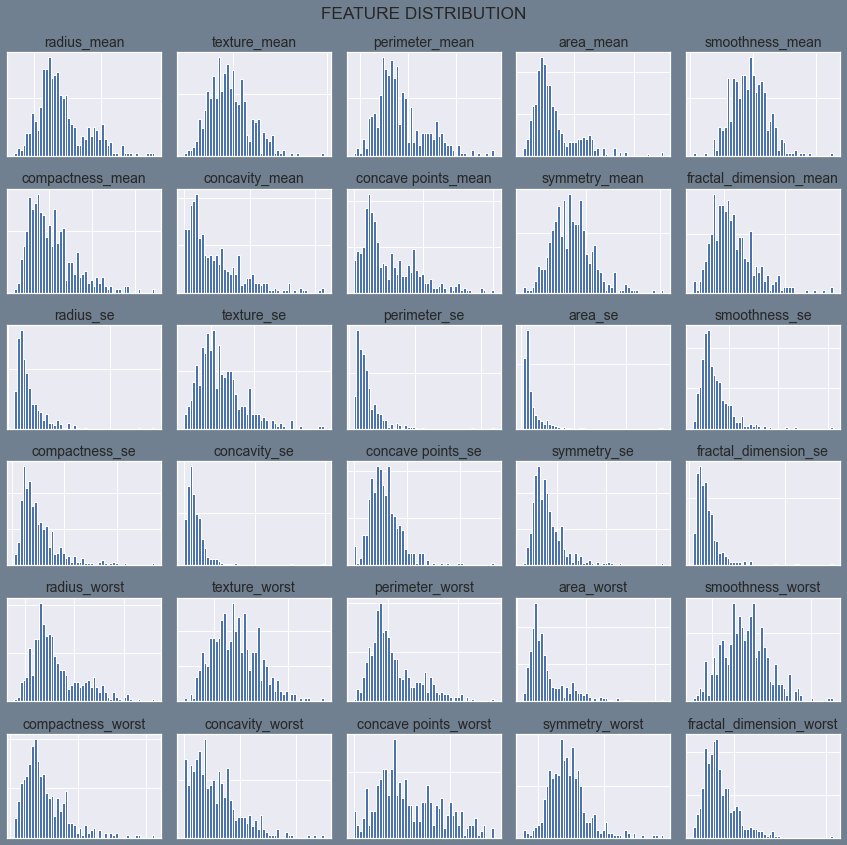

In [9]:
check_distribution(data.iloc[:,1:])

>Judging by the shape, we could assume the majority of features are more or less Normally distributed.
>- Mean and worst present the most Gaussian patterns.
>- Standard error tends to be right skewed, but that's logic assuming the majority of the data will be concentrated close to the lowest measures since we are counting error measures, not measures themselves.


### Outlier Identification


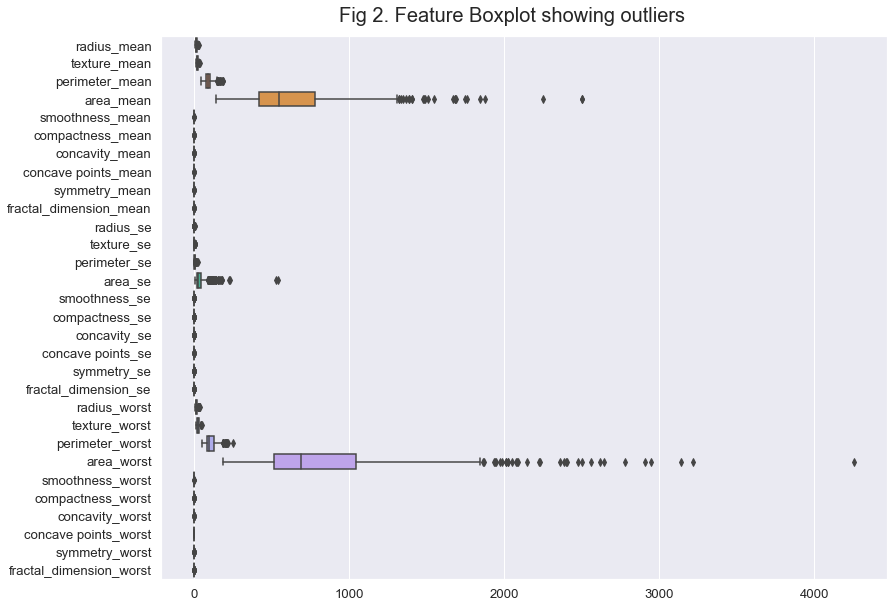

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(13,10))
ax = sb.boxplot(data=data.iloc[:,1:], orient='h')
plt.suptitle('Fig 2. Feature Boxplot showing outliers', fontsize=20, y=0.92)
plt.show()
plt.close()


>We identify 5 features containing most of the dataset outliers, let's check in depth each of these.

In [11]:
# Apply outliers() method on specific columns
outliers(data['area_worst'])
outliers(data['area_mean'])
outliers(data['area_se'])
outliers(data['perimeter_worst'])
outliers(data['perimeter_mean'])

AREA_WORST
Percentiles: 25th=513.950, 75th=1047.000, IQR=533.050
Identified outliers: 33
Non-outlier observations: 422
Outlier Percentage: 7.82 %

AREA_MEAN
Percentiles: 25th=419.250, 75th=777.250, IQR=358.000
Identified outliers: 25
Non-outlier observations: 430
Outlier Percentage: 5.81 %

AREA_SE
Percentiles: 25th=17.695, 75th=45.295, IQR=27.600
Identified outliers: 49
Non-outlier observations: 406
Outlier Percentage: 12.07 %

PERIMETER_WORST
Percentiles: 25th=84.290, 75th=124.950, IQR=40.660
Identified outliers: 14
Non-outlier observations: 441
Outlier Percentage: 3.17 %

PERIMETER_MEAN
Percentiles: 25th=75.015, 75th=103.650, IQR=28.635
Identified outliers: 14
Non-outlier observations: 441
Outlier Percentage: 3.17 %




### Univariate Plot

- **Target Feature**
    
    We plot the diagnosis of our training data so we can get an idea of the target 

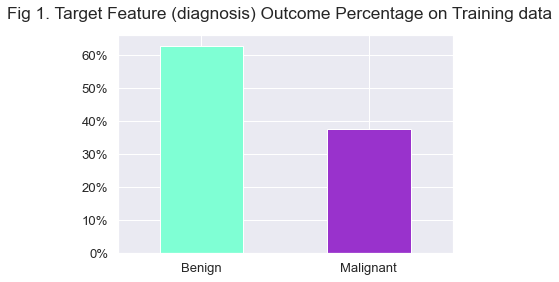

In [12]:
# PLot
my_ticks = {0:'Benign', 1:'Malignant'}
selection = (data['diagnosis'].map(my_ticks)).value_counts(normalize=True).mul(100)
ax = selection.plot(kind='bar',color=['aquamarine','darkorchid'])

# Visuals
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.suptitle('Fig 1. Target Feature (diagnosis) Outcome Percentage on Training data')
plt.xticks(rotation=0, fontsize=13)
plt.show()
plt.close()


### Multivariate Plot



- **Correlation Analysis**

Top 20 Absolute Correlations

radius_mean      perimeter_mean         0.997953
radius_worst     perimeter_worst        0.993830
radius_mean      area_mean              0.986836
perimeter_mean   area_mean              0.986179
radius_worst     area_worst             0.984144
perimeter_worst  area_worst             0.977981
radius_se        perimeter_se           0.973920
perimeter_mean   perimeter_worst        0.973537
radius_mean      radius_worst           0.972981
perimeter_mean   radius_worst           0.972112
radius_mean      perimeter_worst        0.969175
area_mean        area_worst             0.965047
                 radius_worst           0.964526
                 perimeter_worst        0.961693
radius_se        area_se                0.951103
radius_mean      area_worst             0.947690
perimeter_mean   area_worst             0.947474
perimeter_se     area_se                0.939257
concavity_mean   concave points_mean    0.916930
texture_mean     texture_worst         

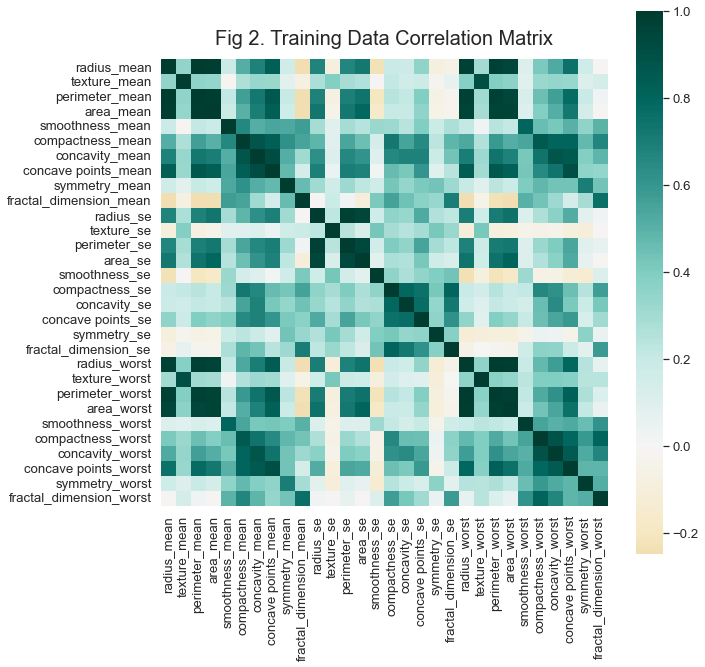

In [13]:
data_corr = data.iloc[:,1:].corr()

print("Top 20 Absolute Correlations\n")
print(get_top_abs_correlations(data, 20))

# Plot
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(data=data_corr,
                square=True,
                cmap='BrBG',
                vmin=-0.25,
                center=0, 
                vmax=1,
                ax=ax)
plt.title('Fig 2. Training Data Correlation Matrix', fontsize=20, y=1.02)
plt.show()
plt.close()

>As seen, a lot of feature combinations present high correlation values. Makes sense since :
>- Area, perimeter and radius are Algebraically intertwined. This relation can be particularly obvious when looking at the SE_subgroup since those are the only ones in dark green.
>- Besides the fact that the three subgroups (wich basically being the mean, the max and the standard error) are a byproduct of the same feature, so for a given "X" feature, x_mean and x_worst will have a strong correlation. 

___

# Pre-processing
___

### Split independent and dependent variables

In [14]:
X = data.loc[:, data.columns != 'diagnosis']
y = data.loc[:, data.columns == 'diagnosis']

### Train/Test split

In [15]:
X_train, X_test, y_train, y_test = (train_test_split(X,y, test_size=0.30, random_state=1))

### Standardization

Based on skewness of the data and the presence of outliers we choose RobustScaler wich is less affected by outliers.

In [16]:
# Define Scaler
scaler = RobustScaler()

# Train it with the Training Input dataset
scaler.fit(X_train)

# Scale Training Input dataset
X_train = scaler.transform(X_train) 

# Scale Test Input Dataset
X_test = scaler.transform(X_test)


### Feature selection methods

- **ANOVA f-test Feature Selection** 


Feature importance scores in ascending value



{'texture_se': 0.01762898723613803,
 'symmetry_se': 0.017631349270699197,
 'fractal_dimension_mean': 0.3495449138510618,
 'fractal_dimension_se': 1.0275333176141646,
 'smoothness_se': 2.0495449287417182,
 'concavity_se': 13.988184805395042,
 'compactness_se': 28.709267724798103,
 'symmetry_mean': 29.02268916940907,
 'fractal_dimension_worst': 32.47906210492114,
 'smoothness_mean': 40.68726730383116,
 'concave points_se': 51.65623387957,
 'texture_mean': 57.25719753003607,
 'smoothness_worst': 62.080349159676636,
 'symmetry_worst': 64.35679409604609,
 'texture_worst': 71.31784963761439,
 'area_se': 80.19526188933213,
 'radius_se': 92.83738756764878,
 'perimeter_se': 93.16078671346257,
 'compactness_mean': 161.14919294081355,
 'compactness_worst': 165.45998791615,
 'concavity_worst': 223.4930399671831,
 'area_mean': 252.40288205034574,
 'concavity_mean': 265.3225446772591,
 'radius_mean': 293.09021469012805,
 'area_worst': 308.49204832557814,
 'perimeter_mean': 315.5847015649933,
 'radiu

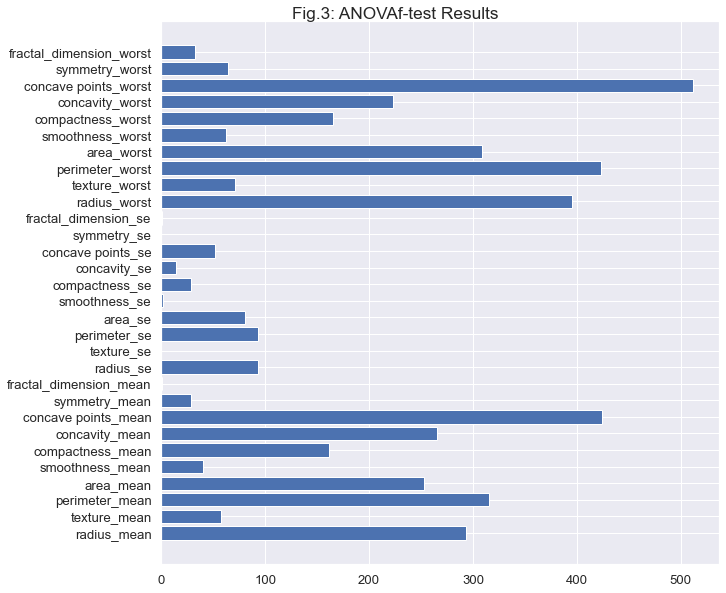

In [17]:
# Call Select_features() method 
fs = select_features(X_train, y_train, X_test)

# Create dictionary with results
d = {}
for i in range(len(fs.scores_)):
    d[i] = fs.scores_[i]
    
# Substitute number for feature names    
feat_list = list(X.columns)
d_named = dict(zip(feat_list, list(d.values()))) 

# Get representation of dict ordered by values
sorted_d = dict(sorted(d_named.items(), key=lambda item:item[1]))

print('\nFeature importance scores in ascending value\n')
display(sorted_d)

# plot scores
fig, ax = plt.subplots(figsize=(10,10))
plt.barh(range(len(d)), list(d.values()), align='center')
plt.yticks(range(len(d)), list(d_named.keys()))
plt.suptitle('Fig.3: ANOVAf-test Results', x=0.45, y=0.9)
plt.show()
plt.close()

>Based on the feature variance obtained, we could try to guess a selected number of features wich might be somewhere around 10 or 15. 

- **Recursive Feature Elimination (RFE)**

In [19]:
# Create rfe and model objects 
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8)

# define the pipeline
steps = [('Feature Elimination',rfe),('Model', LogisticRegression())]
pipeline_rfe = Pipeline(steps=steps)

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=24)
n_scores = cross_val_score(pipeline_rfe, X_train, y_train, 
                           scoring='f1', 
                           cv=cv, 
                           n_jobs=-1)

# Report performance
print('Cross_val F1 Score for RFE + Logistic regression: %.4f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Cross_val F1 Score for RFE + Logistic regression: 0.9355 (0.046)



### Dimensionality Reduction

- **Principal Component Analysis (PCA)**

We will test different PCA models based on number of features selected 

>1 F1 0.880 , Std (0.065)
>2 F1 0.896 , Std (0.056)
>3 F1 0.908 , Std (0.057)
>4 F1 0.920 , Std (0.054)
>5 F1 0.930 , Std (0.045)
>6 F1 0.933 , Std (0.036)
>7 F1 0.927 , Std (0.039)
>8 F1 0.953 , Std (0.038)
>9 F1 0.952 , Std (0.039)
>10 F1 0.952 , Std (0.036)
>11 F1 0.946 , Std (0.039)
>12 F1 0.950 , Std (0.036)
>13 F1 0.949 , Std (0.036)
>14 F1 0.946 , Std (0.038)
>15 F1 0.949 , Std (0.034)
>16 F1 0.952 , Std (0.034)
>17 F1 0.955 , Std (0.033)
>18 F1 0.954 , Std (0.037)
>19 F1 0.952 , Std (0.036)
>20 F1 0.953 , Std (0.034)
>21 F1 0.952 , Std (0.036)
>22 F1 0.952 , Std (0.036)
>23 F1 0.954 , Std (0.037)
>24 F1 0.952 , Std (0.036)
>25 F1 0.952 , Std (0.036)
>26 F1 0.952 , Std (0.036)
>27 F1 0.952 , Std (0.036)
>28 F1 0.952 , Std (0.036)
>29 F1 0.952 , Std (0.036)


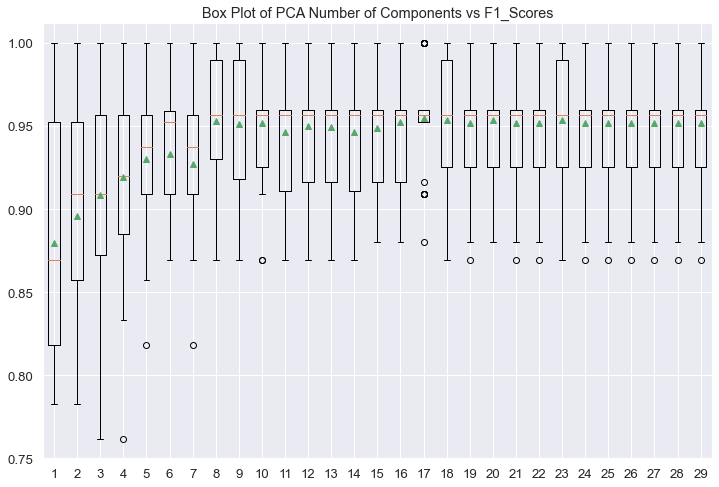

In [18]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,30):
        steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=8)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return scores


# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s F1 %.3f , Std (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
fig,ax = plt.subplots(figsize=(12,8))
ax = plt.boxplot(results, labels=names, showmeans=True)
plt.title('Box Plot of PCA Number of Components vs F1_Scores')
plt.show()
plt.close()

>We would select eight features since it's the smallest number of features delivering the highest score acording to PCA. 

---
# Model Selection
___

- **Random Forest Classifier**

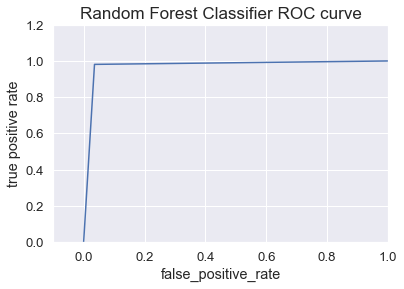


TEST data F1 Score:  0.963 



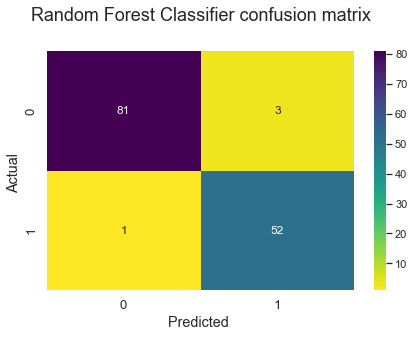

In [20]:
# Create Object
rfc_clasif = RandomForestClassifier()

# Train the model
rfc_clasif.fit(X_train, y_train)

# Predict Values
y_predictions = rfc_clasif.predict(X_test)

# Evaluation metrics
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predictions)
rfc_auc = auc(false_positive_rate, true_positive_rate)
rfc_accur = metrics.accuracy_score(y_test, y_predictions)
precision = metrics.precision_score(y_test, y_predictions) 
recall = metrics.recall_score(y_test, y_predictions)

# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlim([-0.1,1.0])
plt.ylim([0.0,1.2])
plt.title('Random Forest Classifier ROC curve', fontsize=17)
plt.xlabel('false_positive_rate')
plt.ylabel('true positive rate')
plt.show()
plt.close('all')

# report performance
f1 = 2 * (precision * recall) / (precision + recall)
print('\nTEST data F1 Score: ', f1.round(4), '\n')

# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)

# plotting matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis_r" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Random Forest Classifier confusion matrix', y=1.1, fontsize=18)
plt.ylabel('Actual ')
plt.xlabel('Predicted ')
plt.show()
plt.close()


- **Pipeline(PCA+Logistic Regression)**

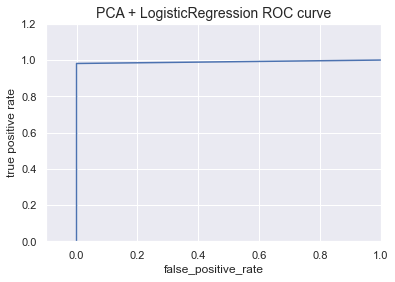


TEST data F1 Score:  0.9905 



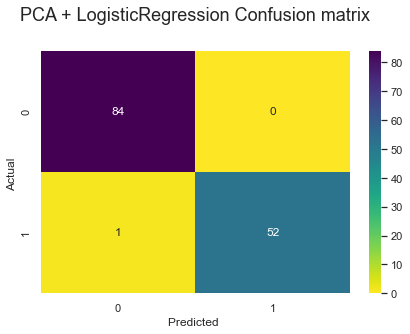

In [21]:
# define the pipeline
steps = [('pca', PCA(n_components=8)), ('m', LogisticRegression())]
pipeline_pca = Pipeline(steps=steps)

# Train the pipeline
pipeline_pca.fit(X_train, y_train)
# make predictions
y_predictions = pipeline_pca.predict(X_test)

# Evaluation metrics
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predictions)
rfc_auc = auc(false_positive_rate, true_positive_rate)
rfc_accur = metrics.accuracy_score(y_test, y_predictions)
precision = metrics.precision_score(y_test, y_predictions) 
recall = metrics.recall_score(y_test, y_predictions)

# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlim([-0.1,1.0])
plt.ylim([0.0,1.2])
plt.title('PCA + LogisticRegression ROC curve', fontsize=14)
plt.xlabel('false_positive_rate')
plt.ylabel('true positive rate')
plt.show()
plt.close('all')

# report performance
f1 = 2 * (precision * recall) / (precision + recall)
print('\nTEST data F1 Score: ', f1.round(4), '\n')

# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)

# plotting matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis_r" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('PCA + LogisticRegression Confusion matrix', y=1.1, fontsize=18)
plt.ylabel('Actual ')
plt.xlabel('Predicted ')
plt.show()
plt.close('all')


- **Pipeline (RFE + Logistic regression**

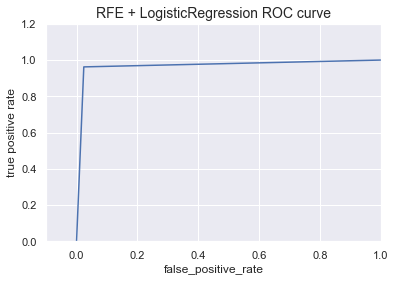

TRAIN cross-validation F1 Score : 0.9355    std: 0.046

TEST data F1 Score:  0.9623 



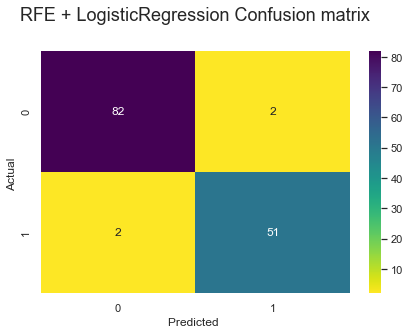

In [22]:
# train pipeline
pipeline_rfe.fit(X_train, y_train)

# make predictions
y_predictions = pipeline_rfe.predict(X_test)

# evaluation metrics
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predictions)
log_auc = auc(false_positive_rate, true_positive_rate)
precision = metrics.precision_score(y_test, y_predictions) 
recall = metrics.recall_score(y_test, y_predictions)

# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlim([-0.1,1.0])
plt.ylim([0.0,1.2])
plt.title('RFE + LogisticRegression ROC curve', fontsize=14)
plt.xlabel('false_positive_rate')
plt.ylabel('true positive rate')
plt.show()
plt.close('all')

# report performance
print('TRAIN cross-validation F1 Score : %.4f    std: %.3f' % (np.mean(n_scores), np.std(n_scores)))
f1 = 2 * (precision * recall) / (precision + recall)
print('\nTEST data F1 Score: ', f1.round(4), '\n')

# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)

# plotting matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis_r" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('RFE + LogisticRegression Confusion matrix', y=1.1, fontsize=18)
plt.ylabel('Actual ')
plt.xlabel('Predicted ')
plt.show()
plt.close()

>Based on the results of the models, i will choose this last one (PCA+logisticregression) since:
>- RFE + logistic regressor seems overfitted
>- This model seems to have more false positives than false negatives, wich in this cancer diagnosis context is the more preferable approach. 

## Test-Data


In [27]:
#Open test data
test = pd.read_csv('C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\Hackathon ITAcademy\\test.csv')
test = pd.DataFrame(test, columns=test.columns)

#Scale with trained object RobustScaler
test = scaler.transform(test)

# make predictions
solution = pipeline_rfe.predict(test)
print(solution)

[0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0
 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0
 0 1 0]


In [24]:
# save to csv file
np.savetxt('predictions.csv', solution, delimiter=',')


# References

- [1]. Muhammet Fatih Ak. A Comparative Analysis of Breast Cancer Detection and Diagnosis Using Data Visualization and Machine Learning Applications. Published online 2020 Apr 26. doi: https://doi.org/10.3390/healthcare8020111